In [2]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install datasets wordcloud 
!{sys.executable} pip install --user -U nltk
!pip install scipy gensim==3.8.3 plotly==4.14.3

/Users/olohireme/opt/anaconda3/bin/python: can't open file 'pip': [Errno 2] No such file or directory
     |████████████████████████████████| 13.2 MB 120 kB/s eta 0:00:01
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11429 sha256=ac25c224ec5a4f21fdb42445df6a2c61be624e1908421c5a3beff4fc211affbd
  Stored in directory: /Users/olohireme/Library/Caches/pip/wheels/c4/a7/48/0a434133f6d56e878ca511c0e6c38326907c0792f67b476e56
Successfully built retrying


In [1]:
# importing the libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import nltk
from nltk.probability import FreqDist
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from gensim.models import Word2Vec, KeyedVectors
from datasets import load_dataset
import gensim.downloader as api
from sklearn.metrics.pairwise import cosine_similarity
import plotly.express as px

In [2]:
# downloading nltk.punkt
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

#### Defining relevant functions

In [3]:
def word_cloud_plot (data):
    """
    function that creates a word cloud from a specified column of a dataframe 
    """
    # create set of stopwords
    stopwords = set(STOPWORDS)

    # Instantiate the word cloud object
    word_cloud = WordCloud(background_color='white',max_words=200,stopwords=stopwords, width=800, height=400)
    
    # generate the word cloud
    word_cloud.generate(' '.join(data))
    
    # To display the word cloud
    plt.figure( figsize=(20,10) )
    plt.imshow(word_cloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [4]:
def regex_filter(sentence):
    """
    funtion that formats string to remove special characters
    """
    import re
    return re.sub('[^a-zA-Z]', ' ', sentence)

In [5]:
def filter_stop_words(token):
    """
    function that removes stopwords from a word-tokenized sentence
    """
    stop_words = set(stopwords.words('english'))
    filtered_token = [word.lower() for word in token if word.lower() not in stop_words]
    return filtered_token

In [6]:
def stem_words(token):
    """
    function that stems word-tokenized sentences
    """
    ps = PorterStemmer()
    stemmed_token = [ps.stem(word) for word in token]
    return stemmed_token

In [7]:
def lemmatize_words(token):
    """
    function that lemmatizes word-tokenized sentences
    """
    lem = WordNetLemmatizer()
    lemmatized_token = [lem.lemmatize(word, 'v') for word in token]
    return lemmatized_token

In [8]:
def join_token(token):
    """
    function that joins word-tokenized sentences back to single string
    """
    return ' '.join(token)

In [9]:
def get_embeddings(group, model):
    group_embedding = []
    group_labels = []
    
    unique_words = [word for sentence in group for word in sentence]
    unique_words = list(dict.fromkeys(unique_words))
    
    for word in unique_words:
        if model.wv.__contains__(word):
            group_embedding.append(list(model.wv.__getitem__(word)))
            group_labels.append(word)
            
    df_embedding = pd.DataFrame(group_embedding)
    df_word = pd.DataFrame(group_labels, columns = ["Word"])
    df = pd.concat([df_word, df_embedding], axis=1)
    return df

In [10]:
def similarity(words, stem_model=None, lem_model=None, W2V_pretrained=None, GloVe_pretrained=None):
    if stem_model:
        ps = PorterStemmer()
        stemmed = [ps.stem(word) for word in words]
        try:
            print("Stemmed W2V model similarity between", words[0], "and", words[1], "=", stem_model.wv.similarity(stemmed[0], stemmed[1]))
        except:
            print("Error: Word not in stem model vocabulary")
    
    if lem_model:
        lem = WordNetLemmatizer()
        lemma = [lem.lemmatize(word, 'v') for word in words]
        try:
            print("Lemmatized W2V model similarity between", words[0], "and", words[1], "=", lem_model.wv.similarity(lemma[0], lemma[1]))
        except:
            print("Error: Word not in lemmatized model vocabulary")        
    
    if W2V_pretrained:
        try:
            print("Word2vec pretrained model similarity between", words[0], "and", words[1], "=", W2V_pretrained.wv.similarity(words[0], words[1]))
        except:
            print("Error: Word not in Word2vec pretrained model vocabulary")
    
    if GloVe_pretrained:
        try:
            print("GloVe pretrained model similarity between", words[0], "and", words[1], "=", GloVe_pretrained.similarity(words[0], words[1]))
        except:
            print("Error: Word not in GloVe pretrained model vocabulary")    

In [11]:
def tsne_plot(df):
    """
    function that plots annotated scatter plot from a dataframe
    """
    plt.figure(figsize=(18, 18)) 
    for i in range(len(df)):
        plt.scatter(df.iloc[i,1],df.iloc[i,2])
        plt.annotate(df.iloc[i,0],
                     xy=(df.iloc[i,1], df.iloc[i,2]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

#### Downloading the dataset

In [12]:
dataset = load_dataset('climate_fever')

df = dataset['test'].to_pandas()
df2 = pd.json_normalize(dataset['test'], 'evidences', ['claim', 'claim_id','claim_label'], errors='ignore',record_prefix='Evidence_')

data1 = df[['claim', 'claim_label']]
data2 = df2[['Evidence_evidence','Evidence_evidence_label']]

Using custom data configuration default
Reusing dataset climate_fever (/Users/olohireme/.cache/huggingface/datasets/climate_fever/default/1.0.1/3b846b20d7a37bc0019b0f0dcbde5bf2d0f94f6874f7e4c398c579f332c4262c)


In [13]:
data1.head()

claim  claim_label
0  Global warming is driving polar bears toward e...            0
1  The sun has gone into ‘lockdown’ which could c...            0
2        The polar bear population has been growing.            1
3  Ironic' study finds more CO2 has slightly cool...            1
4  Human additions of CO2 are in the margin of er...            1

In [14]:
data2.head()

Evidence_evidence  Evidence_evidence_label
0  "Recent Research Shows Human Activity Driving ...                        2
1  Environmental impacts include the extinction o...                        0
2  Rising temperatures push bees to their physiol...                        2
3  Rising global temperatures, caused by the gree...                        0
4    "Bear hunting caught in global warming debate".                        2

#### Histogram plot of claim labels and evidence labels

<AxesSubplot:xlabel='Evidence_evidence_label', ylabel='Count'>

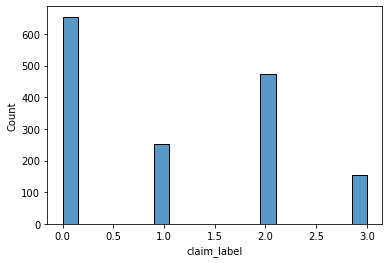

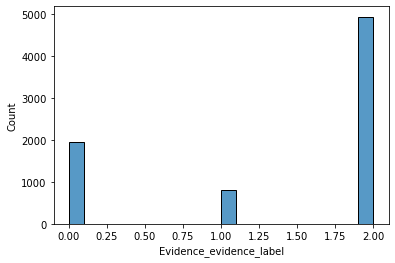

In [15]:
plt.figure()
sns.histplot(data = data1, x ='claim_label', bins = 20)
plt.figure()
sns.histplot(data = data2, x ='Evidence_evidence_label', bins = 20)

#### Word cloud of the claims in the dataset

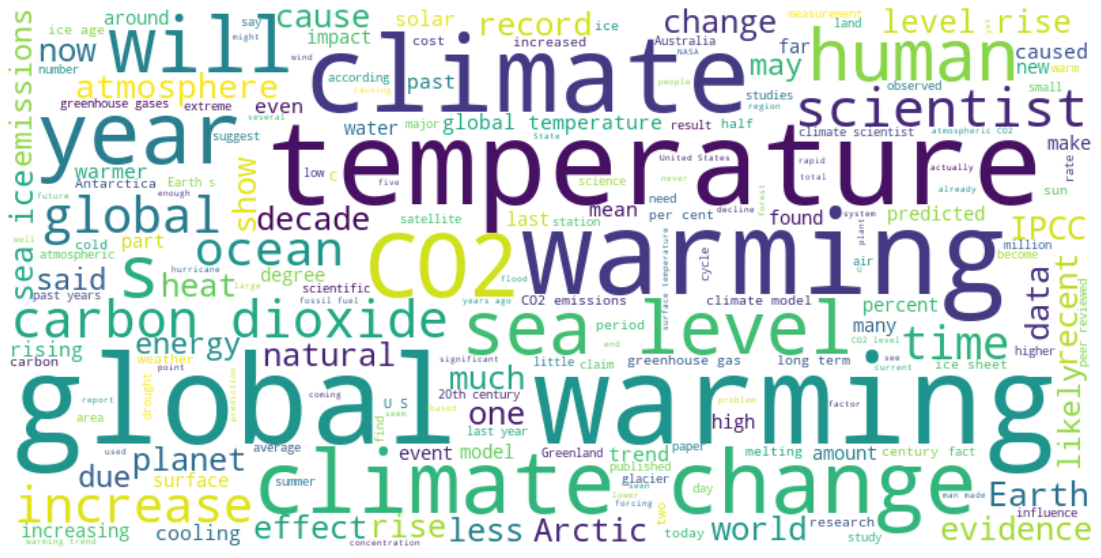

In [16]:
# visualizing word frequency in all claims
word_cloud_plot(data1['claim'])

#### Data preparation

In [17]:
# filter with regex
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim'].apply(regex_filter)

# Tokenizing the claims
data1.loc[:, 'claim_token'] = data1.loc[:, 'claim_token'].apply(nltk.word_tokenize)

# Removing stop words from the claclaim_tokenim tokens
data1.loc[:,'claim_token'] = data1.loc[:,'claim_token'].apply(filter_stop_words)

# Stemming the words
data1.loc[:,'stemmed_words'] = data1.loc[:,'claim_token'].apply(stem_words)

# lemmatizing the words
data1.loc[:,'lemmatized_words'] = data1.loc[:,'claim_token'].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [18]:
data1.head()

claim  claim_label  \
0  Global warming is driving polar bears toward e...            0   
1  The sun has gone into ‘lockdown’ which could c...            0   
2        The polar bear population has been growing.            1   
3  Ironic' study finds more CO2 has slightly cool...            1   
4  Human additions of CO2 are in the margin of er...            1   

                                         claim_token  \
0  [global, warming, driving, polar, bears, towar...   
1  [sun, gone, lockdown, could, cause, freezing, ...   
2                 [polar, bear, population, growing]   
3  [ironic, study, finds, co, slightly, cooled, p...   
4  [human, additions, co, margin, error, current,...   

                                       stemmed_words  \
0  [global, warm, drive, polar, bear, toward, ext...   
1  [sun, gone, lockdown, could, caus, freez, weat...   
2                         [polar, bear, popul, grow]   
3    [iron, studi, find, co, slightli, cool, planet]   
4  [human, addit, co, margin, error, current, mea...   

                                    lemmatized_words  
0  [global, warm, drive, polar, bear, toward, ext...  
1  [sun, go, lockdown, could, cause, freeze, weat...  
2                    [polar, bear, population, grow]  
3  [ironic, study, find, co, slightly, cool, planet]  
4  [human, additions, co, margin, error, current,...

#### Word cloud of the claims in the dataset (after data preparation)

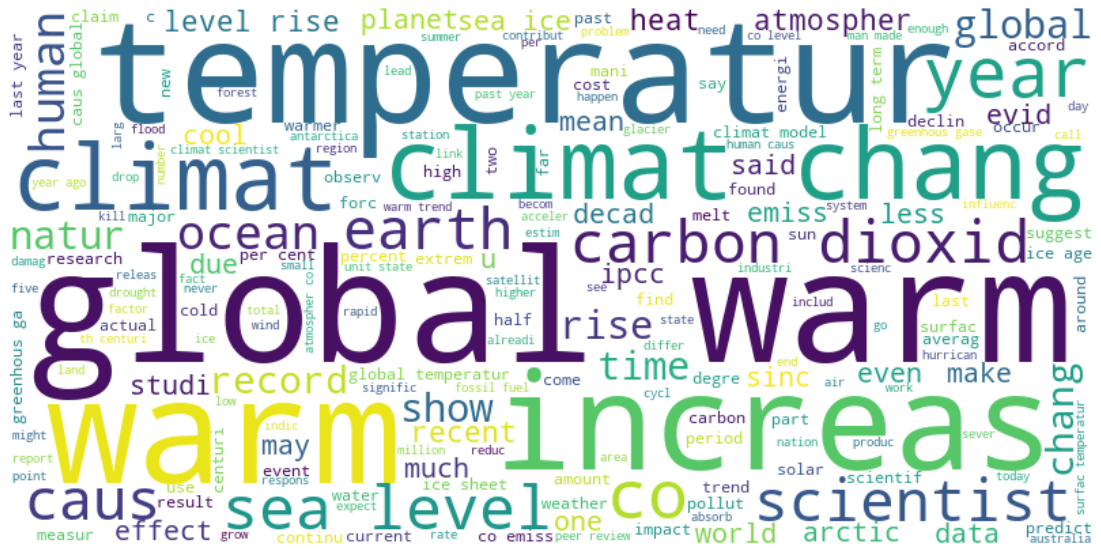

In [19]:
# Visualizing the word cloud again
word_cloud_plot(data1['stemmed_words'].apply(join_token))

#### Creating the corpus

In [20]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(data1['stemmed_words'], test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(data1['lemmatized_words'], test_size=0.2, random_state=0)

#### Training with the whole dataset

In [21]:
# creating the stemmed corpus and lemmatized corpus
corpus_stem = list(data1['stemmed_words'])
corpus_lem = list(data1['lemmatized_words'])

In [22]:
# getting the length of unique stemmed words
unique_set = [word for token in corpus_stem for word in token]
unique_set = set(unique_set)
len(unique_set)

2962

In [23]:
# getting the length of unique lemmatized words
unique_set2 = [word for token in corpus_lem for word in token]
unique_set2 = set(unique_set2)
len(unique_set2)

3324

#### Building the Word2Vec model

In [24]:
# Embeding with Word2Vec
model_stem_claim = Word2Vec(corpus_stem, min_count=1)
model_lem_claim = Word2Vec(corpus_lem, min_count=1)
print(model_stem_claim)
print(model_lem_claim)

Word2Vec(vocab=2962, size=100, alpha=0.025)
Word2Vec(vocab=3324, size=100, alpha=0.025)


In [25]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global']]

In [26]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9776912
Lemmatized W2V model similarity between man and bear = 0.94820803

Stemmed W2V model similarity between heat and warm = 0.99791235
Lemmatized W2V model similarity between heat and warm = 0.9962077

Stemmed W2V model similarity between climate and weather = 0.99657214
Lemmatized W2V model similarity between climate and weather = 0.99332273

Stemmed W2V model similarity between earth and global = 0.99731123
Lemmatized W2V model similarity between earth and global = 0.99356025



#### Adding the evidences to the corpus

In [27]:
# Adding the evidences to increase corpus size

# filer with regex
data2.loc[:, ('evidence_token')] = data2.loc[:, ('Evidence_evidence')].apply(regex_filter)

# Tokenizing the claims
data2.loc[:, ('evidence_token')] = data2.loc[:, ('evidence_token')].apply(nltk.word_tokenize)

# Removing stop words from the evidence_token tokens
data2.loc[:,('evidence_token')] = data2.loc[:,('evidence_token')].apply(filter_stop_words)

# Stemming the words
data2.loc[:,('stemmed_words')] = data2.loc[:,('evidence_token')].apply(stem_words)

# lemmatizing the words
data2.loc[:,('lemmatized_words')] = data2.loc[:,('evidence_token')].apply(lemmatize_words)

/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/olohireme/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [28]:
data2.head()

Evidence_evidence  Evidence_evidence_label  \
0  "Recent Research Shows Human Activity Driving ...                        2   
1  Environmental impacts include the extinction o...                        0   
2  Rising temperatures push bees to their physiol...                        2   
3  Rising global temperatures, caused by the gree...                        0   
4    "Bear hunting caught in global warming debate".                        2   

                                      evidence_token  \
0  [recent, research, shows, human, activity, dri...   
1  [environmental, impacts, include, extinction, ...   
2  [rising, temperatures, push, bees, physiologic...   
3  [rising, global, temperatures, caused, greenho...   
4   [bear, hunting, caught, global, warming, debate]   

                                       stemmed_words  \
0  [recent, research, show, human, activ, drive, ...   
1  [environment, impact, includ, extinct, reloc, ...   
2  [rise, temperatur, push, bee, physiolog, limit...   
3  [rise, global, temperatur, caus, greenhous, ef...   
4          [bear, hunt, caught, global, warm, debat]   

                                    lemmatized_words  
0  [recent, research, show, human, activity, driv...  
1  [environmental, impact, include, extinction, r...  
2  [rise, temperatures, push, be, physiological, ...  
3  [rise, global, temperatures, cause, greenhouse...  
4          [bear, hunt, catch, global, warm, debate]

#### Word cloud of the evidences in the dataset (after data preparation)

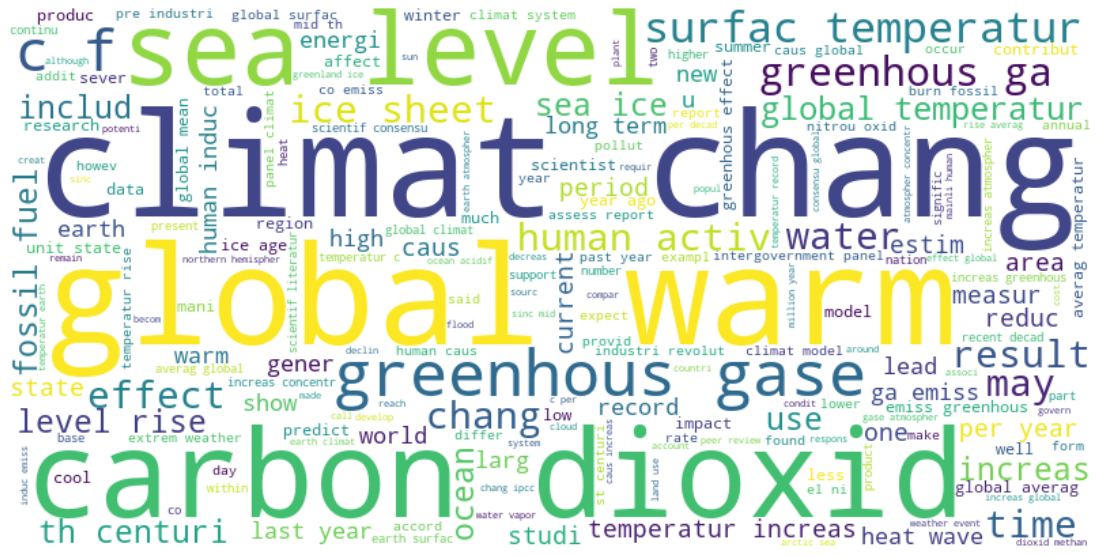

In [29]:
# Visualizing the word cloud of the evidences
word_cloud_plot(data2['stemmed_words'].apply(join_token))

#### Adding the evidences to the corpus

In [30]:
df_stem = pd.concat([data1['stemmed_words'], data2['stemmed_words']])
df_lem = pd.concat([data1['lemmatized_words'], data2['lemmatized_words']])

In [31]:
df_stem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, gone, lockdown, could, caus, freez, weat...
2                           [polar, bear, popul, grow]
3      [iron, studi, find, co, slightli, cool, planet]
4    [human, addit, co, margin, error, current, mea...
Name: stemmed_words, dtype: object

In [32]:
df_lem.head()

0    [global, warm, drive, polar, bear, toward, ext...
1    [sun, go, lockdown, could, cause, freeze, weat...
2                      [polar, bear, population, grow]
3    [ironic, study, find, co, slightly, cool, planet]
4    [human, additions, co, margin, error, current,...
Name: lemmatized_words, dtype: object

In [33]:
from sklearn.model_selection import train_test_split
train_stem, test_stem = train_test_split(df_stem, test_size=0.2, random_state=0)

train_lem, test_lem = train_test_split(df_lem, test_size=0.2, random_state=0)

In [34]:
# adding the sentences in the evidence to the corpus
corpus_stem = list(df_stem)
corpus_lem = list(df_lem)

In [35]:
# getting the length of unique stemmed words
unique_set3 = [word for token in corpus_stem for word in token]
unique_set3 = set(unique_set3)
len(unique_set3)

7433

In [36]:
# getting the length of unique lemmatized words
unique_set4 = [word for token in corpus_lem for word in token]
unique_set4 = set(unique_set4)
len(unique_set4)

9055

#### Building the Word2Vec model

In [37]:
# Embeding with Word2Vec
model_stem_total = Word2Vec(corpus_stem, min_count=1)
model_lem_total = Word2Vec(corpus_lem, min_count=1)
print(model_stem_total)
print(model_lem_total)

Word2Vec(vocab=7433, size=100, alpha=0.025)
Word2Vec(vocab=9055, size=100, alpha=0.025)


In [38]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9093616
Lemmatized W2V model similarity between man and bear = 0.9502071

Stemmed W2V model similarity between heat and warm = 0.66673785
Lemmatized W2V model similarity between heat and warm = 0.6851857

Stemmed W2V model similarity between climate and weather = 0.65958965
Lemmatized W2V model similarity between climate and weather = 0.6939456

Stemmed W2V model similarity between earth and global = 0.9356913
Lemmatized W2V model similarity between earth and global = 0.9329273



#### Comparing with pretrained models

In [39]:
# Loading pretrained Word2Vec model
w2v_data = api.load("text8")
W2V_pretrained = Word2Vec(w2v_data)

In [40]:
# Loading pretrained GloVe model
GloVe_pretrained = api.load("glove-wiki-gigaword-50")

In [41]:
for words in words_list:
    similarity(words = words, 
               stem_model = model_stem_total, 
               lem_model = model_lem_total, 
               W2V_pretrained = W2V_pretrained, 
               GloVe_pretrained = GloVe_pretrained
              )
    print()

Stemmed W2V model similarity between man and bear = 0.9093616
Lemmatized W2V model similarity between man and bear = 0.9502071
Word2vec pretrained model similarity between man and bear = 0.27793646
GloVe pretrained model similarity between man and bear = 0.5815115

Stemmed W2V model similarity between heat and warm = 0.66673785
Lemmatized W2V model similarity between heat and warm = 0.6851857
Word2vec pretrained model similarity between heat and warm = 0.5348385
GloVe pretrained model similarity between heat and warm = 0.68190837

Stemmed W2V model similarity between climate and weather = 0.65958965
Lemmatized W2V model similarity between climate and weather = 0.6939456
Word2vec pretrained model similarity between climate and weather = 0.6114636
GloVe pretrained model similarity between climate and weather = 0.67468363

Stemmed W2V model similarity between earth and global = 0.9356913
Lemmatized W2V model similarity between earth and global = 0.9329273
Word2vec pretrained model similar

In [42]:
model_stem_total.wv['climat']

array([-0.57361215,  0.46940106, -0.5632576 ,  0.27832013, -0.6167497 ,
       -0.73939145, -1.0716472 ,  0.3566435 , -0.21624178,  0.12848888,
        0.3104325 , -0.16819942,  0.11703523,  0.48789108, -1.1703432 ,
        0.5881679 , -0.0645506 ,  0.405193  ,  0.37104222,  0.27467486,
       -0.19075926,  0.6254787 ,  0.2908578 ,  0.7793699 ,  1.2483032 ,
        0.7408656 , -0.09921588, -1.8674729 ,  0.12706232,  0.8692252 ,
        0.548143  ,  1.1210676 ,  0.73780125, -0.23882619,  0.57482445,
       -0.05353522,  0.0308341 , -0.48121476,  0.39743358,  0.30879226,
       -0.14477852,  0.7169375 , -0.48788938,  0.5993881 , -0.2768688 ,
        0.22293134,  0.7984449 , -0.7990682 , -0.08935251, -0.23422362,
        0.92880917, -0.04096489,  0.0587674 ,  0.10070308, -0.11051322,
        0.02363475,  0.22925165,  1.39806   , -0.754584  , -0.8126411 ,
       -0.91073114,  0.84402764,  0.6094279 , -0.2024959 ,  0.28144282,
       -0.670758  ,  0.9079021 , -0.07473873, -0.548617  , -0.15

In [43]:
len(model_stem_total.wv.vocab)

7433

In [44]:
train_embedding_stem = get_embeddings(list(train_stem), model_stem_total)
train_embedding_stem.head()

Word         0         1         2         3         4         5  \
0   includ  0.032313  0.612207 -0.249352  0.242763 -0.413612 -0.357065   
1  process  0.224934  0.602974 -0.145179  0.240347 -0.125174 -0.400941   
2   variat  0.235696  0.754967  0.022414  0.205930 -0.207981 -0.624346   
3    solar  0.127372  0.673175 -0.194596  0.197477 -0.155116 -0.454874   
4   radiat  0.353371  0.740784 -0.064956  0.116554  0.084894 -0.389808   

          6         7         8  ...        90        91        92        93  \
0 -0.625463  0.425412  0.213225  ...  0.316909  0.385922  0.162102  0.197411   
1 -0.412556  0.233420  0.144217  ...  0.112854  0.252445  0.171429  0.324515   
2 -0.466246  0.178821  0.212249  ...  0.001875  0.569213  0.294752  0.256924   
3 -0.496118  0.243821 -0.021930  ...  0.206280  0.093590  0.177180  0.338809   
4 -0.392743  0.126007  0.298771  ... -0.075241  0.179306  0.006470  0.508634   

         94        95        96        97        98        99  
0 -0.541736 -0.500492 -0.209913 -0.037004 -0.282269 -0.083702  
1 -0.399395 -0.499752 -0.025107 -0.119406 -0.270499 -0.117249  
2 -0.263057 -0.576009 -0.152259 -0.096734 -0.448994 -0.037914  
3 -0.336726 -0.626305 -0.040192 -0.191537 -0.449386 -0.244104  
4 -0.418200 -0.584712 -0.030193 -0.213792 -0.229697 -0.061330  

[5 rows x 101 columns]

In [45]:
train_embedding_lem = get_embeddings(list(train_lem), model_lem_total)
train_embedding_lem.head()

Word         0         1         2         3         4         5  \
0     include  0.020725  0.564501 -0.885372  0.694273 -0.094497  0.206580   
1     process -0.007167  0.462788 -0.820352  0.433052  0.181533  0.009284   
2  variations  0.153565  0.267227 -0.482488  0.496331  0.108675 -0.147424   
3       solar -0.046411  0.529953 -0.962976  0.464450  0.157990 -0.046318   
4   radiation  0.052324  0.524837 -0.645531  0.435147  0.327328 -0.027544   

          6         7         8  ...        90        91        92        93  \
0 -0.079119  1.204692  0.383343  ... -0.532797  0.342967  0.320351  0.193350   
1  0.109298  1.064577  0.164576  ... -0.510553  0.358413  0.199017  0.352167   
2  0.040554  0.641031  0.151901  ... -0.308679  0.326239  0.276182  0.277355   
3  0.114731  1.313712  0.205841  ... -0.423313  0.389650  0.157393  0.452859   
4  0.012748  0.790611  0.111003  ... -0.688532  0.328426  0.237377  0.484202   

         94        95        96        97        98        99  
0  0.570612 -0.163456 -0.755201 -0.477852 -0.699673 -0.209430  
1  0.507724 -0.214606 -0.641947 -0.415206 -0.746081 -0.598142  
2  0.355867 -0.416171 -0.476571 -0.278039 -0.514705 -0.327341  
3  0.581508 -0.400325 -0.899468 -0.494223 -1.041482 -0.690914  
4  0.384536 -0.086925 -0.499035 -0.337894 -0.628680 -0.631569  

[5 rows x 101 columns]

#### Getting the test set embeddings

In [46]:
test_embedding_stem = get_embeddings(list(test_stem), model_stem_total)
test_embedding_stem.head()

Word         0         1         2         3         4         5  \
0   choic  0.040956  0.134617  0.000254  0.051938 -0.049547 -0.097970   
1  author  0.147990  0.641153 -0.028862  0.255426 -0.270623 -0.526145   
2     aim  0.100493  0.350396 -0.009439  0.129268 -0.125627 -0.300565   
3    rang  0.355620  1.255822  0.152400  0.283966 -0.296070 -1.030393   
4    view  0.089711  0.468724 -0.009730  0.182221 -0.235473 -0.436757   

          6         7         8  ...        90        91        92        93  \
0 -0.079752  0.024670  0.034303  ...  0.019691  0.105408  0.064336  0.026083   
1 -0.454510  0.131066  0.150980  ...  0.128742  0.527321  0.313452  0.114123   
2 -0.242926  0.064660  0.078666  ...  0.044001  0.281794  0.168250  0.072129   
3 -0.838622  0.124030  0.575187  ... -0.253219  1.056154  0.517364  0.261626   
4 -0.353730  0.098046  0.118554  ...  0.086064  0.473427  0.258059  0.061845   

         94        95        96        97        98        99  
0 -0.042293 -0.091958 -0.010133 -0.010617 -0.086202 -0.018076  
1 -0.236957 -0.474334 -0.050006 -0.037443 -0.399817 -0.135058  
2 -0.120163 -0.258374 -0.035106 -0.032180 -0.230816 -0.065548  
3 -0.342721 -0.644473 -0.362507 -0.064654 -0.673673 -0.054643  
4 -0.188407 -0.354666 -0.041440 -0.018873 -0.291403 -0.053969  

[5 rows x 101 columns]

In [47]:
test_embedding_lem = get_embeddings(list(test_lem), model_lem_total)
test_embedding_lem.head()

Word         0         1         2         3         4         5  \
0  choice  0.026590  0.028768 -0.066199  0.068314  0.012702 -0.018829   
1  author  0.101973  0.208447 -0.446191  0.416745  0.049113 -0.119601   
2     aim  0.075005  0.143383 -0.291865  0.269851  0.051651 -0.088335   
3   range  0.574834  0.350425 -0.481450  1.144904  0.176334 -0.485518   
4    view  0.088767  0.207675 -0.433679  0.394405  0.042684 -0.112068   

          6         7         8  ...        90        91        92        93  \
0  0.009849  0.081209  0.022229  ... -0.028808  0.039922  0.030774  0.030220   
1  0.051320  0.561777  0.152314  ... -0.189584  0.269627  0.202661  0.123403   
2  0.031721  0.359247  0.089035  ... -0.161276  0.176073  0.144957  0.107712   
3 -0.120243  0.558016  0.277295  ... -0.604333  0.508987  0.757182  0.407268   
4  0.035119  0.519821  0.136309  ... -0.217279  0.256678  0.220368  0.130421   

         94        95        96        97        98        99  
0  0.046362 -0.054327 -0.056743 -0.037672 -0.064690 -0.038755  
1  0.286714 -0.348508 -0.382290 -0.201181 -0.419917 -0.261421  
2  0.200812 -0.223673 -0.266972 -0.141783 -0.289569 -0.190778  
3  0.431534 -0.859815 -0.640155 -0.386360 -0.559066 -0.292541  
4  0.279493 -0.321179 -0.412580 -0.191917 -0.411856 -0.229363  

[5 rows x 101 columns]

#### Getting Cosine similarity between all  words

In [48]:
cos_sim_w2v = cosine_similarity(test_embedding_stem.iloc[:,1:].values, Y=None, dense_output=True)

In [49]:
cos_sim_w2v.shape

(3783, 3783)

In [50]:
cos_sim_w2v = pd.DataFrame(cos_sim_w2v, columns = list(test_embedding_stem["Word"]), index = list(test_embedding_stem["Word"]))

In [51]:
cos_sim_w2v.head()

choic    author       aim      rang      view  expertis  geograph  \
choic   1.000000  0.992473  0.991684  0.843813  0.965510  0.976011  0.994340   
author  0.992473  1.000000  0.998058  0.858333  0.985863  0.990578  0.993948   
aim     0.991684  0.998058  1.000000  0.869787  0.984836  0.987026  0.995165   
rang    0.843813  0.858333  0.869787  1.000000  0.896373  0.869642  0.887704   
view    0.965510  0.985863  0.984836  0.896373  1.000000  0.994343  0.980059   

        represent     ensur    expert  ...   recharg   lithium  activist  \
choic    0.992744  0.997298  0.987180  ...  0.960641  0.981934  0.987323   
author   0.994879  0.996175  0.997848  ...  0.957439  0.983798  0.992249   
aim      0.996024  0.997217  0.995613  ...  0.965386  0.987563  0.992775   
rang     0.868690  0.864278  0.864635  ...  0.937223  0.916959  0.849047   
view     0.979809  0.976785  0.990635  ...  0.955788  0.978829  0.972994   

            talk   pathway   utterli    barren       fog    sweden    vanish  
choic   0.996229  0.906926  0.986252  0.994123  0.989765  0.978119  0.945773  
author  0.994807  0.908150  0.990392  0.988226  0.986743  0.973711  0.953920  
aim     0.994619  0.920463  0.992461  0.988082  0.988421  0.977435  0.956015  
rang    0.845248  0.820457  0.902900  0.830418  0.888678  0.914942  0.949503  
view    0.972783  0.880730  0.987422  0.956696  0.971088  0.964961  0.967430  

[5 rows x 3783 columns]

### Arithmetic Relationships
Scientist, peer, review, publish
greenhouse, carbon, dioxide
decade, year, today

In [52]:
#Relationship 1
#ICE + WARM - COLD = WATER/SEA/OCEAN
model_stem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('rise', 0.8607549667358398),
 ('level', 0.8423374891281128),
 ('contribut', 0.788809061050415),
 ('acceler', 0.7887903451919556),
 ('arctic', 0.7886830568313599)]

In [53]:
model_lem_total.wv.most_similar(positive=['ice', 'warm'], negative=['cold'], topn=5)

[('level', 0.8825053572654724),
 ('rise', 0.8813116550445557),
 ('sea', 0.8517345786094666),
 ('amplification', 0.8329085111618042),
 ('ocean', 0.8290849328041077)]

In [54]:
#Relationship 2
#dark + sun - night = day/light
model_stem_total.wv.most_similar(positive=['hydro', 'gase'], negative=['carbon'],  topn=5)

[('timescal', 0.9641864895820618),
 ('accur', 0.9634714722633362),
 ('endors', 0.9634604454040527),
 ('impact', 0.9622740149497986),
 ('variabl', 0.960005521774292)]

In [55]:
model_lem_total.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('impact', 0.9682196378707886),
 ('evidence', 0.9679965972900391),
 ('artifact', 0.9671837687492371),
 ('reflection', 0.9670667052268982),
 ('hothouse', 0.9664155840873718)]

In [56]:
#Relationship 3
#rising + gradual - increasing = slow
model_stem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increas'],  topn=5)

[('shrunk', 0.9729684591293335),
 ('ft', 0.966210126876831),
 ('retreat', 0.9580646753311157),
 ('metr', 0.9577291011810303),
 ('outflow', 0.9563913345336914)]

In [57]:
#rising + gradual - increasing
model_lem_total.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('ft', 0.9408212900161743),
 ('antarctic', 0.9316974878311157),
 ('refroze', 0.9311459064483643),
 ('extents', 0.9311279058456421),
 ('metres', 0.9283707141876221)]

In [58]:
#Relationship 4
#summer + cold - solar = winter
model_stem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'],  topn=5)

[('northernmost', 0.9781622886657715),
 ('pari', 0.97206050157547),
 ('everi', 0.9712003469467163),
 ('decemb', 0.9694790244102478),
 ('juli', 0.9686945080757141)]

In [59]:
model_lem_total.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=5)

[('every', 0.9757681488990784),
 ('compute', 0.9717823266983032),
 ('medium', 0.9709124565124512),
 ('pi', 0.9701552987098694),
 ('nino', 0.9699885249137878)]

In [60]:
#Relationship 5
#climate + temperature - weather
model_stem_total.wv.most_similar(positive=['climat', 'temperatur'], negative=['weather'],  topn=5)

[('consensu', 0.8929864168167114),
 ('overwhelm', 0.8724015355110168),
 ('unequivoc', 0.8519541025161743),
 ('global', 0.8510343432426453),
 ('recent', 0.8436861634254456)]

In [61]:
model_lem_total.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('potentials', 0.9156714677810669),
 ('consensus', 0.8933898210525513),
 ('unequivocal', 0.8882666826248169),
 ('observe', 0.8875494003295898),
 ('global', 0.8764916658401489)]

In [62]:
W2V_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

[('rocks', 0.6628645658493042),
 ('snow', 0.6545249223709106),
 ('climbing', 0.6220051050186157),
 ('frozen', 0.6214287281036377),
 ('beds', 0.6192962527275085)]

In [63]:
GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)

<ipython-input-63-1ec3bbdb9b68>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['ice', 'warm'], negative=['cold'],  topn=5)


[('plate', 0.7150593996047974),
 ('silver', 0.6485081911087036),
 ('sparkling', 0.636193573474884),
 ('skate', 0.6235347986221313),
 ('cream', 0.6151865720748901)]

In [64]:
W2V_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

[('electricity', 0.6054819822311401),
 ('liquified', 0.601629912853241),
 ('petrol', 0.5897268056869507),
 ('liquefied', 0.5746511816978455),
 ('tanker', 0.567954421043396)]

In [65]:
GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)

<ipython-input-65-2ba09357030c>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['hydro', 'gas'], negative=['carbon'],  topn=5)


[('statoil', 0.7187291383743286),
 ('pipeline', 0.6830664873123169),
 ('refinery', 0.6819669008255005),
 ('hydroelectric', 0.6683335304260254),
 ('electricity', 0.6475889682769775)]

In [66]:
W2V_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

[('emergence', 0.5832725763320923),
 ('modernism', 0.5822501182556152),
 ('postwar', 0.5420085191726685),
 ('radicalization', 0.5359699726104736),
 ('chaos', 0.5186872482299805)]

In [67]:
GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)

<ipython-input-67-026c8898a0fe>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['rise', 'gradual'], negative=['increase'],  topn=5)


[('inexorable', 0.7363816499710083),
 ('upturn', 0.7345753908157349),
 ('precipitous', 0.725489616394043),
 ('stagnation', 0.7136895060539246),
 ('downward', 0.6995311379432678)]

In [68]:
W2V_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

[('south', 0.6443580985069275),
 ('west', 0.51485276222229),
 ('nisjoki', 0.4622754454612732)]

In [69]:
GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)

<ipython-input-69-7d315d12d06e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['north', 'pole'], negative=['arctic'], topn=3)


[('fifth', 0.7316383719444275),
 ('third', 0.7275133728981018),
 ('sixth', 0.7260597348213196)]

In [70]:
W2V_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

[('enthalpy', 0.6184506416320801),
 ('temperatures', 0.6143823266029358),
 ('salinity', 0.5669232606887817),
 ('entropy', 0.5635480880737305),
 ('pressures', 0.561367392539978)]

In [71]:
GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)

<ipython-input-71-92ac769b420e>:1: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  GloVe_pretrained.wv.most_similar(positive=['climate', 'temperature'], negative=['weather'],  topn=5)


[('carbon', 0.7083598375320435),
 ('warming', 0.6987556219100952),
 ('greenhouse', 0.680810809135437),
 ('co2', 0.6696141958236694),
 ('ph', 0.6661812663078308)]

### Applying KNN on the Embeddings

In [72]:
knn_data_stem = data1[['claim', 'stemmed_words', 'claim_label']]
knn_data_stem.head()

claim  \
0  Global warming is driving polar bears toward e...   
1  The sun has gone into ‘lockdown’ which could c...   
2        The polar bear population has been growing.   
3  Ironic' study finds more CO2 has slightly cool...   
4  Human additions of CO2 are in the margin of er...   

                                       stemmed_words  claim_label  
0  [global, warm, drive, polar, bear, toward, ext...            0  
1  [sun, gone, lockdown, could, caus, freez, weat...            0  
2                         [polar, bear, popul, grow]            1  
3    [iron, studi, find, co, slightli, cool, planet]            1  
4  [human, addit, co, margin, error, current, mea...            1

In [73]:
def get_sentence_embedding(data, column, train_word_embedding, test_word_embedding):
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            if word in train_word_embedding.index:
                embeddings.append(train_word_embedding.loc[word])
            else:
                embeddings.append(test_word_embedding.loc[word])
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([df["claim"], df, df["claim_label"]], axis=1)
    return df   

In [74]:
def get_sentence_embedding(data, column, model):
    sentence_embeddings = []
    for token in data[column]:
        embeddings = []
        for word in token:
            embeddings.append(list(model.wv.__getitem__(word)))
        
        embedding_array = np.array(embeddings)
        sentence_embedding = np.mean(embedding_array, axis=0)
        sentence_embeddings.append(list(sentence_embedding))
        
    features = len(sentence_embeddings[0])
    df = pd.DataFrame(sentence_embeddings, columns = ["feature_"+ str(i+1) for i in range(features)])
    df = pd.concat([data[["claim", column]], df, data["claim_label"]], axis=1)
    return df   

In [75]:
get_sentence_embedding(knn_data_stem, 'stemmed_words', model_stem_total)

claim  \
0     Global warming is driving polar bears toward e...   
1     The sun has gone into ‘lockdown’ which could c...   
2           The polar bear population has been growing.   
3     Ironic' study finds more CO2 has slightly cool...   
4     Human additions of CO2 are in the margin of er...   
...                                                 ...   
1530  About 60% of the warming observed from 1970 to...   
1531  "Skeptics hope that Postma’s alternative therm...   
1532  "There are other possible causes for climate c...   
1533  We don't need a high heat flow - just a high t...   
1534  Over the last decade, heatwaves are five times...   

                                          stemmed_words  feature_1  feature_2  \
0     [global, warm, drive, polar, bear, toward, ext...   0.233817   0.671851   
1     [sun, gone, lockdown, could, caus, freez, weat...   0.144069   0.538885   
2                            [polar, bear, popul, grow]   0.292884   0.735318   
3       [iron, studi, find, co, slightli, cool, planet]   0.266504   0.615670   
4     [human, addit, co, margin, error, current, mea...   0.413653   0.637789   
...                                                 ...        ...        ...   
1530  [warm, observ, like, caus, natur, year, climat...   0.189154   0.771993   
1531  [skeptic, hope, postma, altern, thermal, model...   0.112378   0.482417   
1532  [possibl, caus, climat, chang, could, associ, ...   0.191185   0.749188   
1533  [need, high, heat, flow, high, temperatur, cor...   0.288861   0.928844   
1534  [last, decad, heatwav, five, time, like, globa...   0.342226   0.874147   

      feature_3  feature_4  feature_5  feature_6  feature_7  feature_8  ...  \
0      0.001360   0.187170  -0.188334  -0.545436  -0.423641   0.195352  ...   
1     -0.006043   0.141259  -0.176617  -0.430097  -0.359310   0.134349  ...   
2      0.065246   0.278936  -0.287006  -0.541932  -0.415118   0.195197  ...   
3      0.007043   0.196632  -0.067420  -0.483983  -0.351738   0.106358  ...   
4      0.035333   0.189790   0.016168  -0.508604  -0.277688   0.137958  ...   
...         ...        ...        ...        ...        ...        ...  ...   
1530  -0.061358   0.185767  -0.155855  -0.821883  -0.522117   0.116975  ...   
1531  -0.013872   0.181250  -0.215417  -0.397294  -0.354403   0.113032  ...   
1532  -0.050042   0.181616  -0.166381  -0.665901  -0.539304   0.160461  ...   
1533  -0.006834   0.212872  -0.146872  -0.682787  -0.641293   0.177220  ...   
1534   0.117909   0.175896  -0.076430  -0.900289  -0.448203   0.052160  ...   

      feature_92  feature_93  feature_94  feature_95  feature_96  feature_97  \
0       0.560360    0.177366    0.286048   -0.371188   -0.498358   -0.146069   
1       0.375719    0.161176    0.176562   -0.254553   -0.399640   -0.144428   
2       0.728635    0.351885    0.154742   -0.176062   -0.516308   -0.058852   
3       0.429704    0.199176    0.269135   -0.264890   -0.434018   -0.087299   
4       0.428408    0.127386    0.362092   -0.340627   -0.441004   -0.082969   
...          ...         ...         ...         ...         ...         ...   
1530    0.474033    0.119213    0.344564   -0.570477   -0.671068   -0.225537   
1531    0.442121    0.246871    0.084388   -0.175391   -0.352541   -0.067977   
1532    0.471377    0.187911    0.299270   -0.424202   -0.549399   -0.181822   
1533    0.655372    0.307724    0.352479   -0.389053   -0.573781   -0.268452   
1534    0.692211    0.201159    0.370568   -0.439487   -0.613955   -0.247094   

      feature_98  feature_99  feature_100  claim_label  
0      -0.088661   -0.285041     0.050829            0  
1      -0.039231   -0.279381    -0.036002            0  
2      -0.044256   -0.432771    -0.028115            1  
3      -0.111573   -0.294202    -0.036859            1  
4      -0.131611   -0.225244     0.065612            1  
...          ...         ...          ...          ...  
1530   -0.149864   -0.333827     0.000276            2  
15

## PCA

### CM2

### Q.1 Using Stemming

In [76]:
from sklearn.decomposition import PCA
n_components = 30
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
explained_variance = pca.explained_variance_ratio_

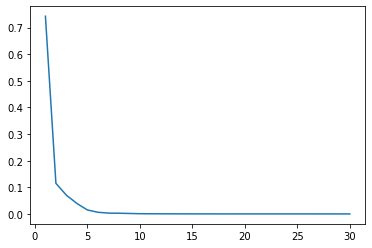

In [77]:
plt.plot(range(1, n_components + 1), explained_variance)

Explained variance tells us how much information can be attributed to each of the principal components. The explained variance reduces as the number of components increases which shows that most of the information is held by the first 5 components. 
The "elbow" of the graph is where the value of explained variance seems to level off and factors or components to the left of this point should be retained as significant.


### Q.2 
**From the scree plot above, the best dimensionality is 5**

In [78]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_stem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_stem.iloc[:,1:].values)

### Q.3 


In [79]:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_stem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

Word      PC_1      PC_2      PC_3      PC_4      PC_5
0   choic -0.029219  0.028129 -0.077040  0.045244  0.013446
1  author  2.579051  0.149307 -0.592015 -0.118468  0.010285
2     aim  1.088539  0.067994 -0.228057 -0.074648  0.068486
3    rang  3.820586 -1.911794  0.467660 -0.580408  0.024025
4    view  1.701143 -0.136049 -0.389225 -0.383553 -0.084960

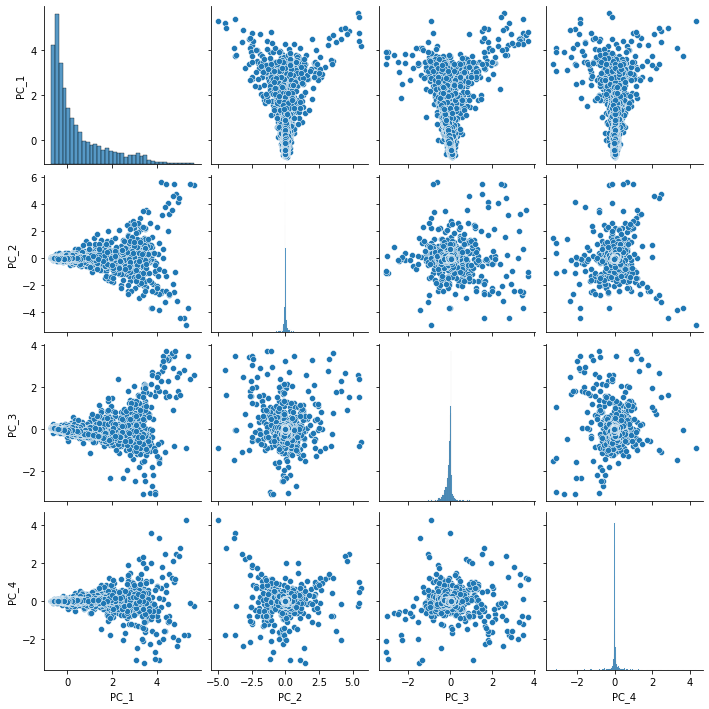

In [80]:
sns.pairplot(pca_test.iloc[:,1:5])

In [81]:
pca_test.shape

(3783, 6)

In [140]:
columns = ['PC_1','PC_2','PC_3','PC_4','PC_5']
df_pca = pd.DataFrame(pca_test, columns = columns)
df_pca.max() - df_pca.min()

PC_1     6.566654
PC_2    10.603688
PC_3     6.016285
PC_4     7.692284
PC_5     5.405992
dtype: float64

#### Discussion on PCA embeddings 
- The first principle component is highly skewed to the left. It has a lot of variance, this is likely because about 70% of the variance in the data comes from this feature
- The variance in the second, third and fourth principal components is quite small
- The first four principal components have little or no correlation with each other. 
- The largest range of embeddings in 10.6
- PCA speed, compare running times of all 4 methods


### Using Lemmatization

In [82]:
pca = PCA(n_components=n_components)
pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
explained_variance = pca.explained_variance_ratio_

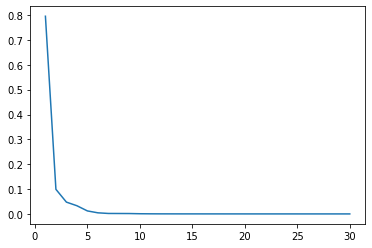

In [83]:
plt.plot(range(1, n_components + 1), explained_variance)

In [84]:
# Building optimal PCA model
pca = PCA(n_components=5)
pca_train = pca.fit_transform(train_embedding_lem.iloc[:,1:].values)
pca_test = pca.transform(test_embedding_lem.iloc[:,1:].values)

In [85]:
pca_test = pd.DataFrame(pca_test, columns = columns)
pca_test["Word"] = test_embedding_lem["Word"]
pca_test = pca_test[['Word','PC_1','PC_2','PC_3','PC_4','PC_5']]
pca_test.head()

Word      PC_1      PC_2      PC_3      PC_4      PC_5
0  choice -0.227666  0.001961 -0.004804 -0.004726  0.001515
1  author  2.050421  0.180997 -0.364513 -0.195045  0.015727
2     aim  1.197511  0.113315 -0.119860 -0.114008  0.034368
3   range  4.526133 -1.760346  0.279620 -0.521132 -0.071246
4    view  2.024193  0.171365 -0.234782 -0.347746 -0.049430

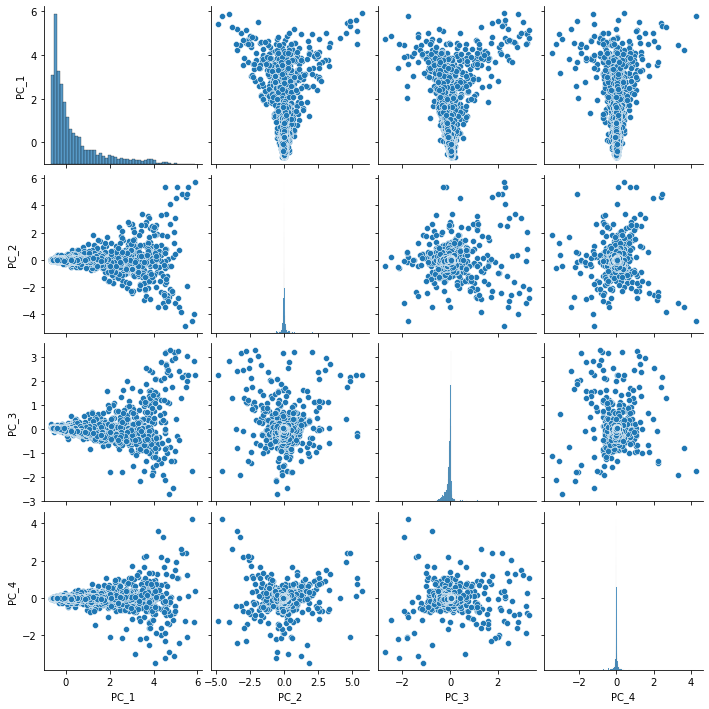

In [86]:
sns.pairplot(pca_test.iloc[:,1:5])

#### Q.4 Getting Cosine similarity between all  words

In [87]:
cos_sim_pca = cosine_similarity(pca_test.iloc[:,1:].values, Y=None, dense_output=False)

In [88]:
cos_sim_pca.shape

(4402, 4402)

In [89]:
cos_sim_pca = pd.DataFrame(cos_sim_pca, columns = list(pca_test["Word"]), index = list(pca_test["Word"]))
cos_sim_pca

choice    author       aim     range      view  expertise  \
choice    1.000000 -0.969730 -0.980366 -0.926790 -0.968660  -0.882226   
author   -0.969730  1.000000  0.996907  0.872257  0.994885   0.963119   
aim      -0.980366  0.996907  1.000000  0.882375  0.995708   0.945635   
range    -0.926790  0.872257  0.882375  1.000000  0.884468   0.802270   
view     -0.968660  0.994885  0.995708  0.884468  1.000000   0.965371   
...            ...       ...       ...       ...       ...        ...   
barren    0.999443 -0.975779 -0.985217 -0.929094 -0.975786  -0.895519   
fog       0.995747 -0.965386 -0.976704 -0.952969 -0.970127  -0.886027   
sweden    0.991527 -0.988654 -0.994346 -0.883289 -0.984871  -0.919652   
rotation  0.677370 -0.806603 -0.795953 -0.437797 -0.804084  -0.845145   
vanish    0.986839 -0.989973 -0.996431 -0.874204 -0.985125  -0.918491   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.635574        0.976367 -0.974967 -0.956135  ...   0.975013   
author       -0.695734       -0.929747  0.992705  0.998040  ...  -0.976589   
aim          -0.714945       -0.953826  0.989745  0.990117  ...  -0.975410   
range        -0.382826       -0.863641  0.870924  0.858111  ...  -0.939117   
view         -0.722079       -0.938393  0.977630  0.989317  ...  -0.967287   
...                ...             ...       ...       ...  ...        ...   
barren        0.642226        0.973496 -0.978073 -0.963148  ...   0.979074   
fog           0.611801        0.966882 -0.964827 -0.951082  ...   0.979435   
sweden        0.703200        0.970477 -0.988906 -0.979371  ...   0.970167   
rotation      0.903883        0.698059 -0.770329 -0.813969  ...   0.672186   
vanish        0.714735        0.968507 -0.990664 -0.980768  ...   0.971095   

          pathways   methods   sectors   utterly    barren       fog  \
choice    0.993988 -0.981176  0.994436  0.956665  0.999443  0.995747   
author   -0.988031  0.994226 -0.964895 -0.904732 -0.975779 -0.965386   
aim      -0.992076  0.991418 -0.974015 -0.923651 -0.985217 -0.976704   
range    -0.900269  0.908231 -0.958702 -0.800099 -0.929094 -0.952969   
view     -0.980885  0.985846 -0.968614 -0.899846 -0.975786 -0.970127   
...            ...       ...       ...       ...       ...       ...   
barren    0.995227 -0.985417  0.995749  0.949456  1.000000  0.996938   
fog       0.985966 -0.978627  0.999254  0.930294  0.996938  1.000000   
sweden    0.997970 -0.988342  0.979718  0.956525  0.993037  0.982016   
rotation  0.735721 -0.741024  0.642119  0.685674  0.690534  0.653555   
vanish    0.995784 -0.987201  0.973960  0.948255  0.989072  0.977854   

            sweden  rotation    vanish  
choice    0.991527  0.677370  0.986839  
author   -0.988654 -0.806603 -0.989973  
aim      -0.994346 -0.795953 -0.996431  
range    -0.883289 -0.437797 -0.874204  
view     -0.984871 -0.804084 -0.985125  
...            ...       ...       ...  
barren    0.993037  0.690534  0.989072  
fog       0.982016  0.653555  0.977854  
sweden    1.000000  0.764423  0.997930  
rotation  0.764423  1.000000  0.781334  
vanish    0.997930  0.781334  1.000000  

[4402 rows x 4402 columns]

In [90]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'], ['scientist', 'publish']]
for word in words_list:
    print("The Cos similarity of PCA embeddings between", word[0], "and", word[1], "is", cos_sim_pca.at[word[0], word[1]])
    similarity(words = word, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )

The Cos similarity of PCA embeddings between man and bear is 0.9050716504773323
Stemmed W2V model similarity between man and bear = 0.9776912
Lemmatized W2V model similarity between man and bear = 0.94820803
The Cos similarity of PCA embeddings between heat and warm is 0.647054992050343
Stemmed W2V model similarity between heat and warm = 0.99791235
Lemmatized W2V model similarity between heat and warm = 0.9962077
The Cos similarity of PCA embeddings between climate and weather is 0.6823472678256665
Stemmed W2V model similarity between climate and weather = 0.99657214
Lemmatized W2V model similarity between climate and weather = 0.99332273
The Cos similarity of PCA embeddings between earth and global is 0.9411930022054086
Stemmed W2V model similarity between earth and global = 0.99731123
Lemmatized W2V model similarity between earth and global = 0.99356025
The Cos similarity of PCA embeddings between scientist and publish is 0.96176457865574
Stemmed W2V model similarity between scienti

In [91]:
#cosine similarity by cluster. 
#Since cosine similarity with words by every other word is not possible. 
#Or maybe most common words with their 20 neighbours from KNN
#Definition and formula for Cosine similarity

### Notes About Cosine Similarity
Cosine Similarity computes the L2-normalized dot product of vectors. That is, if $x$  and $y$ are row vectors, their cosine similarity $k$ is defined as:

$k(x,y) = \frac{xy^T}{\|x\|y\|}$


Negative values of cosine similarity denote a strongly opposite correlation between words.

## CM3 - LLE

### Q.1 Using Stemming

In [92]:
from sklearn.manifold import LocallyLinearEmbedding

In [93]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

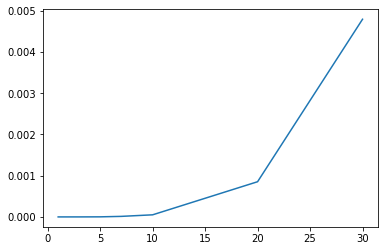

In [94]:
plt.plot(n_components, reconstruction_error)

From the plot above we can see that the reconstruction error increases with the number of components. Why?, supposed to reduce according to sklearn docs

In [104]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_stem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [105]:
df_lle.head()

Word  feature1  feature2  feature3  feature4
0   choic  0.001407  0.005394  0.014388 -0.017841
1  author  0.000951 -0.026776 -0.007131  0.003052
2     aim  0.002255 -0.024664  0.006661  0.016412
3    rang -0.002618 -0.026399 -0.005789  0.004859
4    view  0.001341 -0.025877 -0.002332  0.007412

In [106]:
lle_model.reconstruction_error_

4.2217754977849897e-07

### Q.2

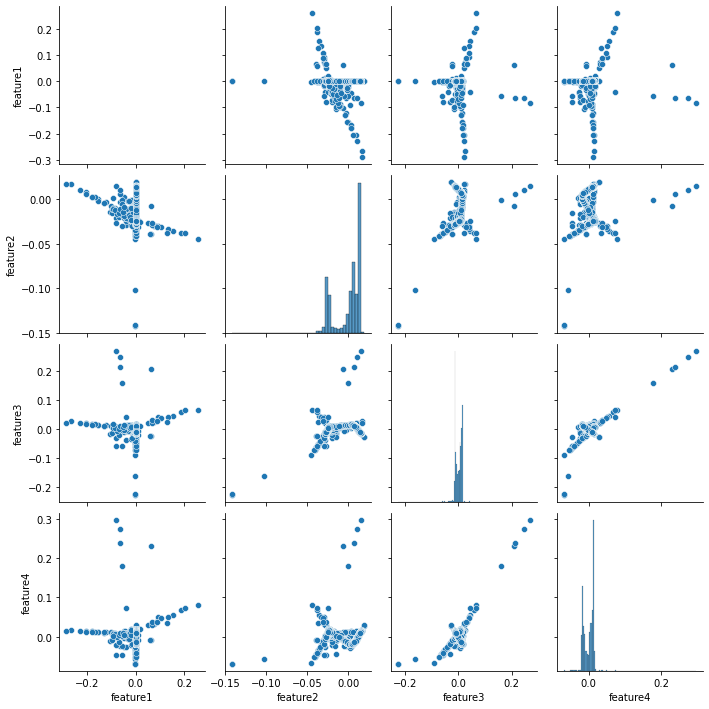

In [107]:
sns.pairplot(df_lle.iloc[:,1:5])

### Using Lemmatization

In [108]:
n_components = [1, 2, 3, 5, 7, 10, 20, 30]
reconstruction_error = []
for n in n_components:
    lle_model = LocallyLinearEmbedding(n_components=n, random_state=0)
    lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)
    reconstruction_error.append(lle_model.reconstruction_error_)

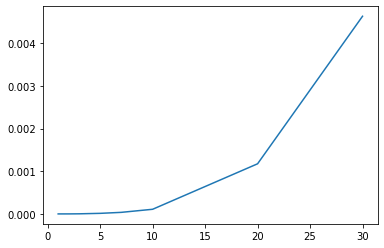

In [109]:
plt.plot(n_components, reconstruction_error)

Applying LLE on the lemmatized corpus has a slightly lower reconstruction error as compared to the stemmed corpus

In [110]:
lle_model = LocallyLinearEmbedding(n_components=4, random_state=0)
lle_vectors = lle_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

df_lle = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_lle["Word"] = test_embedding_lem["Word"]
df_lle = df_lle[["Word", "feature1", "feature2", "feature3", "feature4"]]

In [111]:
df_lle.head()

Word  feature1  feature2  feature3  feature4
0  choice -0.006575 -0.012018  0.015878  0.023492
1  author  0.018992  0.019310  0.009875  0.016596
2     aim  0.017846  0.013708 -0.004626  0.019309
3   range  0.019311  0.021467  0.022598 -0.023841
4    view  0.018985  0.019276  0.009766  0.016792

In [139]:
df_l = pd.DataFrame(lle_vectors, columns = ["feature1", "feature2", "feature3", "feature4"])
df_l.max() - df_l.min()

feature1    0.044693
feature2    0.074641
feature3    0.114425
feature4    0.169404
dtype: float64

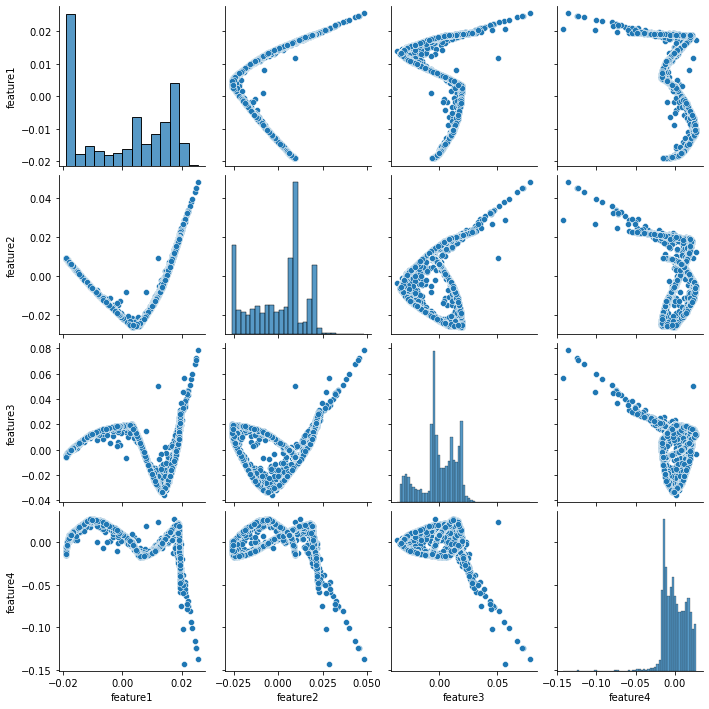

In [112]:
sns.pairplot(df_lle.iloc[:,1:5])

###  Discussions on the LLE Embeddings

- The largest range of embeddings is 0.04
- For the lemmatized corpus, the plot of feature 1 and feature 2 has a parabolic shape
- However, the plots of all the other features are arbitrary shapes.
- The distribution of the feature 3 is skewed to the left while the distribution of feature 4 is skewed to the right

In [113]:
lle_model.reconstruction_error_

7.508187708783053e-06

### Q.3 Getting Cosine similarity between all  words

In [114]:
cos_sim_lle = cosine_similarity(df_lle.iloc[:,1:].values, Y=None, dense_output=False)

In [115]:
cos_sim_lle.shape

(4402, 4402)

In [116]:
cos_sim_lle = pd.DataFrame(cos_sim_lle, columns = list(df_lle["Word"]), index = list(df_lle["Word"]))
cos_sim_lle

choice    author       aim     range      view  expertise  \
choice    1.000000  0.181124  0.103781 -0.425657  0.184069  -0.539288   
author    0.181124  1.000000  0.879924  0.418439  0.999978  -0.363393   
aim       0.103781  0.879924  1.000000  0.056390  0.882500   0.027972   
range    -0.425657  0.418439  0.056390  1.000000  0.412413  -0.310001   
view      0.184069  0.999978  0.882500  0.412413  1.000000  -0.361357   
...            ...       ...       ...       ...       ...        ...   
barren    0.368821 -0.106776 -0.099610 -0.461717 -0.104267  -0.508198   
fog       0.955489  0.236898  0.202741 -0.501939  0.240588  -0.578381   
sweden    0.964648  0.230731  0.190249 -0.494207  0.234338  -0.579024   
rotation  0.468546 -0.319919 -0.473875 -0.012180 -0.321181  -0.081625   
vanish    0.372139 -0.116559 -0.112542 -0.461618 -0.114088  -0.511618   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.384147        0.582131  0.117739 -0.157277  ...   0.996401   
author       -0.365331       -0.231841  0.893968  0.538968  ...   0.146803   
aim          -0.513833       -0.402492  0.999484  0.864830  ...   0.056145   
range         0.020748       -0.035691  0.073928 -0.199920  ...  -0.400657   
view         -0.366912       -0.232751  0.896433  0.542745  ...   0.149458   
...                ...             ...       ...       ...  ...        ...   
barren       -0.458056       -0.331206 -0.092549 -0.209572  ...   0.309925   
fog           0.106234        0.323718  0.215722 -0.056930  ...   0.927733   
sweden        0.138149        0.354404  0.203473 -0.071556  ...   0.939510   
rotation      0.995548        0.989921 -0.467023 -0.525072  ...   0.541524   
vanish       -0.446786       -0.320643 -0.105354 -0.222725  ...   0.314122   

          pathways   methods   sectors   utterly    barren       fog  \
choice   -0.513458 -0.238251  0.198050  0.613255  0.368821  0.955489   
author   -0.549487  0.391230 -0.203950 -0.214828 -0.106776  0.236898   
aim      -0.586802  0.766634 -0.199044 -0.383804 -0.099610  0.202741   
range     0.039476 -0.272035 -0.395971 -0.054797 -0.461717 -0.501939   
view     -0.551496  0.395170 -0.202142 -0.215567 -0.104267  0.240588   
...            ...       ...       ...       ...       ...       ...   
barren    0.493630 -0.237454  0.981291 -0.305957  1.000000  0.590845   
fog      -0.366506 -0.144184  0.428629  0.359894  0.590845  1.000000   
sweden   -0.382203 -0.158584  0.406493  0.390154  0.570103  0.999455   
rotation -0.427079 -0.509702 -0.468921  0.983993 -0.406945  0.197211   
vanish    0.497009 -0.249883  0.981626 -0.295563  0.999897  0.591627   

            sweden  rotation    vanish  
choice    0.964648  0.468546  0.372139  
author    0.230731 -0.319919 -0.116559  
aim       0.190249 -0.473875 -0.112542  
range    -0.494207 -0.012180 -0.461618  
view      0.234338 -0.321181 -0.114088  
...            ...       ...       ...  
barren    0.570103 -0.406945  0.999897  
fog       0.999455  0.197211  0.591627  
sweden    1.000000  0.228773  0.571204  
rotation  0.228773  1.000000 -0.395884  
vanish    0.571204 -0.395884  1.000000  

[4402 rows x 4402 columns]

In [117]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'], ['scientist', 'publish']]
for word in words_list:
    print("The Cos similarity of LLE embeddings between", word[0], "and", word[1], "is", cos_sim_lle.at[word[0], word[1]])
    similarity(words = word, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )

The Cos similarity of LLE embeddings between man and bear is 0.2345401313314131
Stemmed W2V model similarity between man and bear = 0.9776912
Lemmatized W2V model similarity between man and bear = 0.94820803
The Cos similarity of LLE embeddings between heat and warm is 0.9429738681705981
Stemmed W2V model similarity between heat and warm = 0.99791235
Lemmatized W2V model similarity between heat and warm = 0.9962077
The Cos similarity of LLE embeddings between climate and weather is 0.9911862973928233
Stemmed W2V model similarity between climate and weather = 0.99657214
Lemmatized W2V model similarity between climate and weather = 0.99332273
The Cos similarity of LLE embeddings between earth and global is 0.9978317910150482
Stemmed W2V model similarity between earth and global = 0.99731123
Lemmatized W2V model similarity between earth and global = 0.99356025
The Cos similarity of LLE embeddings between scientist and publish is 0.5908799400286695
Stemmed W2V model similarity between scie

## TSNE

### Using Stemming

In [118]:
from sklearn.manifold import TSNE

### Q.1 tSNE Dimensionality
- Plot different number of components with KL-Divergence

In [119]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_stem.iloc[:,1:].values)

In [120]:
df_tsne = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne["Word"] = test_embedding_stem["Word"]
df_tsne = df_tsne[["Word", "feature1", "feature2"]]

In [121]:
df_tsne.head()

Word   feature1   feature2
0   choic -10.419395  26.138391
1  author  59.051037 -21.695353
2     aim  36.161892   3.011918
3    rang  74.144806  -6.734217
4    view  47.391396  -9.701619

In [137]:
df_t = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_t.max() - df_t.min()

feature1    171.800201
feature2    106.311348
dtype: float32

### Q.2 Discussions on tSNE embedding

- The range of embeddings are much higher than that of PCA and LLE, with the highest range being 170
- The scatter plot of features produces an S-shaped curve, why?

In [122]:
fig = px.scatter(df_tsne, x="feature1", y="feature2",
                 hover_name="Word")
fig.show()

In [123]:
tsne_model.kl_divergence_

1.058139681816101

In [124]:
tsne_model.n_iter_

999

### Using Lemmatization

In [125]:
tsne_model = TSNE(n_components=2, init='pca', random_state=0)
tsne_vectors = tsne_model.fit_transform(test_embedding_lem.iloc[:,1:].values)

In [126]:
df_tsne_lem = pd.DataFrame(tsne_vectors, columns = ["feature1", "feature2"])
df_tsne_lem["Word"] = test_embedding_lem["Word"]
df_tsne_lem = df_tsne_lem[["Word", "feature1", "feature2"]]

In [127]:
fig = px.scatter(df_tsne_lem, x="feature1", y="feature2",
                 hover_name="Word")
fig.show()

In [128]:
tsne_model.kl_divergence_

1.1060620546340942

In [129]:
tsne_model.n_iter_

999

In [130]:
cos_sim_tsne = cosine_similarity(df_tsne_lem.iloc[:,1:].values, Y=None, dense_output=False)

In [131]:
cos_sim_tsne.shape

(4402, 4402)

In [132]:
cos_sim_tsne = pd.DataFrame(cos_sim_tsne, columns = list(df_tsne_lem["Word"]), index = list(df_tsne_lem["Word"]))
cos_sim_tsne

choice    author       aim     range      view  expertise  \
choice    1.000000 -0.289593 -0.736130 -0.070035 -0.278178  -0.929475   
author   -0.289593  1.000000  0.861015  0.975081  0.999929  -0.083909   
aim      -0.736130  0.861015  1.000000  0.726732  0.854900   0.434538   
range    -0.070035  0.975081  0.726732  1.000000  0.977653  -0.302885   
view     -0.278178  0.999929  0.854900  0.977653  1.000000  -0.095767   
...            ...       ...       ...       ...       ...        ...   
barren    0.443775 -0.986253 -0.933218 -0.925017 -0.984216  -0.081905   
fog       0.900464 -0.677063 -0.957238 -0.496927 -0.668254  -0.676518   
sweden    0.971615 -0.507803 -0.875353 -0.304033 -0.497511  -0.815826   
rotation  0.856009  0.246914 -0.280235  0.455741  0.258433  -0.986338   
vanish    0.501342 -0.973358 -0.954688 -0.898236 -0.970560  -0.146806   

          geographical  representation    ensure   experts  ...  reactions  \
choice        0.748306        0.864611 -0.744835 -0.844404  ...   0.999012   
author        0.418224        0.230526  0.854356  0.757285  ...  -0.331848   
aim          -0.101867       -0.296395  0.999916  0.984179  ...  -0.765486   
range         0.609317        0.440655  0.717775  0.593529  ...  -0.114302   
view          0.429008        0.242094  0.848109  0.749456  ...  -0.320594   
...                ...             ...       ...       ...  ...        ...   
barren       -0.262376       -0.066563 -0.928486 -0.854793  ...   0.483166   
fog           0.385309        0.560023 -0.960904 -0.993351  ...   0.918904   
sweden        0.570139        0.721209 -0.881542 -0.947166  ...   0.981169   
rotation      0.983485        0.999858 -0.292644 -0.445879  ...   0.832187   
vanish       -0.198809       -0.001271 -0.950753 -0.886855  ...   0.539303   

          pathways   methods   sectors   utterly    barren       fog  \
choice    0.556406 -0.888208  0.232162  0.871032  0.443775  0.900464   
author   -0.956437  0.696974 -0.998230  0.217932 -0.986253 -0.677063   
aim      -0.971981  0.964805 -0.829248 -0.308712 -0.933218 -0.957238   
range    -0.867838  0.520519 -0.986548  0.429017 -0.925017 -0.496927   
view     -0.952894  0.688388 -0.998868  0.229535 -0.984216 -0.668254   
...            ...       ...       ...       ...       ...       ...   
barren    0.991530 -0.805888  0.974681 -0.053664  1.000000  0.789362   
fog       0.862413 -0.999625  0.632101  0.570683  0.789362  1.000000   
sweden    0.737179 -0.971685  0.455675  0.730100  0.643175  0.977794   
rotation  0.046741 -0.522800 -0.304103  0.999556 -0.083392  0.545963   
vanish    0.997894 -0.842828  0.958001  0.011652  0.997866  0.827764   

            sweden  rotation    vanish  
choice    0.971615  0.856009  0.501342  
author   -0.507803  0.246914 -0.973358  
aim      -0.875353 -0.280235 -0.954688  
range    -0.304033  0.455741 -0.898236  
view     -0.497511  0.258433 -0.970560  
...            ...       ...       ...  
barren    0.643175 -0.083392  0.997866  
fog       0.977794  0.545963  0.827764  
sweden    1.000000  0.709416  0.691801  
rotation  0.709416  1.000000 -0.018147  
vanish    0.691801 -0.018147  1.000000  

[4402 rows x 4402 columns]

tSNE should have the longest running times.


### Q.3 Comparing Cosine Similarity of Word2Vec with tSNE

In [133]:
words_list = [['man', 'bear'],['heat', 'warm'],['climate', 'weather'],['earth', 'global'], ['scientist', 'publish']]
for word in words_list:
    print("The Cos similarity of tSNE embeddings between", word[0], "and", word[1], "is", cos_sim_tsne.at[word[0], word[1]])
    similarity(words = word, 
               stem_model = model_stem_claim, 
               lem_model = model_lem_claim
              )

The Cos similarity of tSNE embeddings between man and bear is 0.83213603
Stemmed W2V model similarity between man and bear = 0.9776912
Lemmatized W2V model similarity between man and bear = 0.94820803
The Cos similarity of tSNE embeddings between heat and warm is 0.99738014
Stemmed W2V model similarity between heat and warm = 0.99791235
Lemmatized W2V model similarity between heat and warm = 0.9962077
The Cos similarity of tSNE embeddings between climate and weather is 0.98316145
Stemmed W2V model similarity between climate and weather = 0.99657214
Lemmatized W2V model similarity between climate and weather = 0.99332273
The Cos similarity of tSNE embeddings between earth and global is 0.9999718
Stemmed W2V model similarity between earth and global = 0.99731123
Lemmatized W2V model similarity between earth and global = 0.99356025
The Cos similarity of tSNE embeddings between scientist and publish is 0.8386836
Stemmed W2V model similarity between scientist and publish = 0.9871998
Lemmati